In [2]:
pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 55.8 MB/s eta 0:00:00


In [3]:
!pip install scikit-learn --upgrade

In [4]:
import torch
import timm
import faiss
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [6]:
model = timm.create_model("regnety_040", pretrained=True, features_only=True)  # feature extraction
model.eval().to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/82.9M [00:00<?, ?B/s]

FeatureListNet(
  (stem): ConvNormAct(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): ReLU(inplace=True)
    )
  )
  (s1): RegStage(
    (b1): Bottleneck(
      (conv1): ConvNormAct(
        (conv): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNormAct2d(
          128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): ReLU(inplace=True)
        )
      )
      (conv2): ConvNormAct(
        (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=2, bias=False)
        (bn): BatchNormAct2d(
          128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): ReLU(inplace=True)
        )
      )
      (se): SEModule(
        (fc1): Conv2d

In [7]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])


In [8]:
def load_cifar100():
    dataset = datasets.CIFAR100(root="./data", train=True, download=True, transform=transform)
    dataloader = DataLoader(dataset, batch_size=128, shuffle=False, num_workers=2)
    return dataset, dataloader

In [9]:
def get_regnet_embeddings(dataloader):
    all_features = []
    model.eval()

    with torch.no_grad():
        for images, _ in dataloader:
            images = images.to(device)

            # Extract last feature map
            features = model(images)[-1]
            pooled = torch.nn.functional.adaptive_avg_pool2d(features, 1).squeeze(-1).squeeze(-1)

            all_features.append(pooled.cpu().numpy())

    return np.vstack(all_features)


In [10]:
def build_faiss_index(embeddings):
    index = faiss.IndexFlatL2(embeddings.shape[1])
    index.add(embeddings)
    return index

In [11]:
def faiss_search(index, query_embedding, k=50):
    _, indices = index.search(query_embedding, k)
    return indices[0]

In [12]:
def compute_metrics(retrieved_indices, query_labels, database_labels, k=50):
    total_tp, total_fp = 0, 0
    for i in range(len(query_labels)):
        retrieved = retrieved_indices[i]
        retrieved_labels = database_labels[retrieved]
        tp = np.sum(retrieved_labels == query_labels[i])
        fp = k - tp
        total_tp += tp
        total_fp += fp
    total_retrieved = len(query_labels) * k
    return total_tp / total_retrieved, total_fp / total_retrieved


In [13]:
def show_results(query_img, faiss_idxs, original_dataset, query_label=None, faiss_precision=None, faiss_fpr=None):
    fig = plt.figure(figsize=(20, 12))
    ax = plt.subplot(6, 10, 1)
    ax.imshow(query_img.permute(1, 2, 0))
    ax.set_title("Query\n(Class: Unknown)" if query_label is None else f"Query\n(Class: {label_names[query_label]})")
    ax.axis("off")
    for i, idx in enumerate(faiss_idxs[:50]):
        img, label = original_dataset[idx]
        ax = plt.subplot(6, 10, i + 2)
        ax.imshow(img.permute(1, 2, 0).clamp(0, 1))
        ax.set_title(f"FAISS {i+1}\n{label_names[label]}", fontsize=8)
        ax.axis("off")
    if faiss_precision is not None:
        fig.suptitle(f"Precision: {faiss_precision:.3f} | FPR: {faiss_fpr:.3f}", fontsize=16)
    plt.tight_layout()
    plt.show()

Loading dataset and model...
Files already downloaded and verified



Query 1 (Index: 300, Label: plain):
Top-10: Precision = 0.300, FPR = 0.700
Top-20: Precision = 0.250, FPR = 0.750
Top-30: Precision = 0.200, FPR = 0.800
Top-40: Precision = 0.250, FPR = 0.750
Top-50: Precision = 0.280, FPR = 0.720


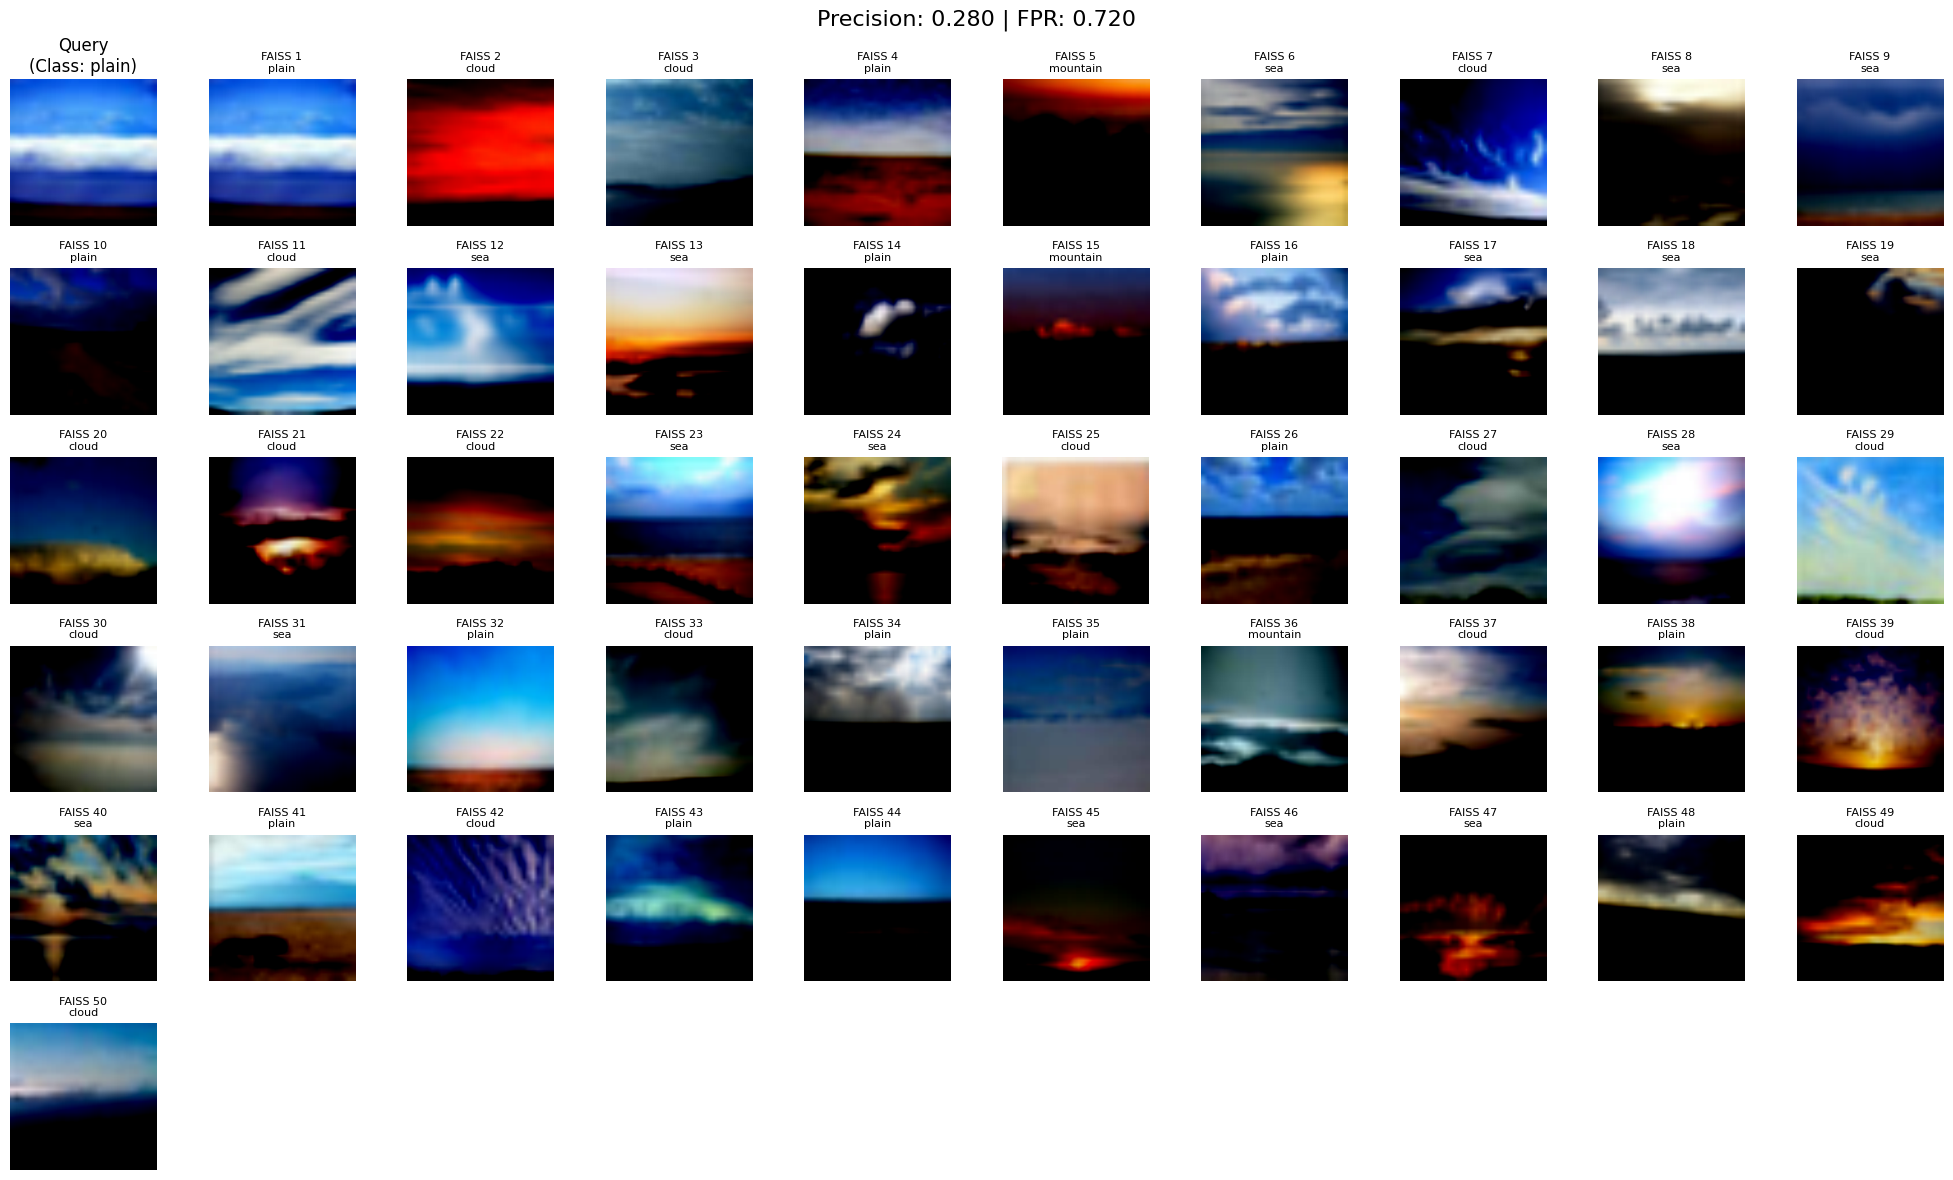


Query 2 (Index: 10, Label: keyboard):
Top-10: Precision = 0.700, FPR = 0.300
Top-20: Precision = 0.550, FPR = 0.450
Top-30: Precision = 0.600, FPR = 0.400
Top-40: Precision = 0.625, FPR = 0.375
Top-50: Precision = 0.600, FPR = 0.400


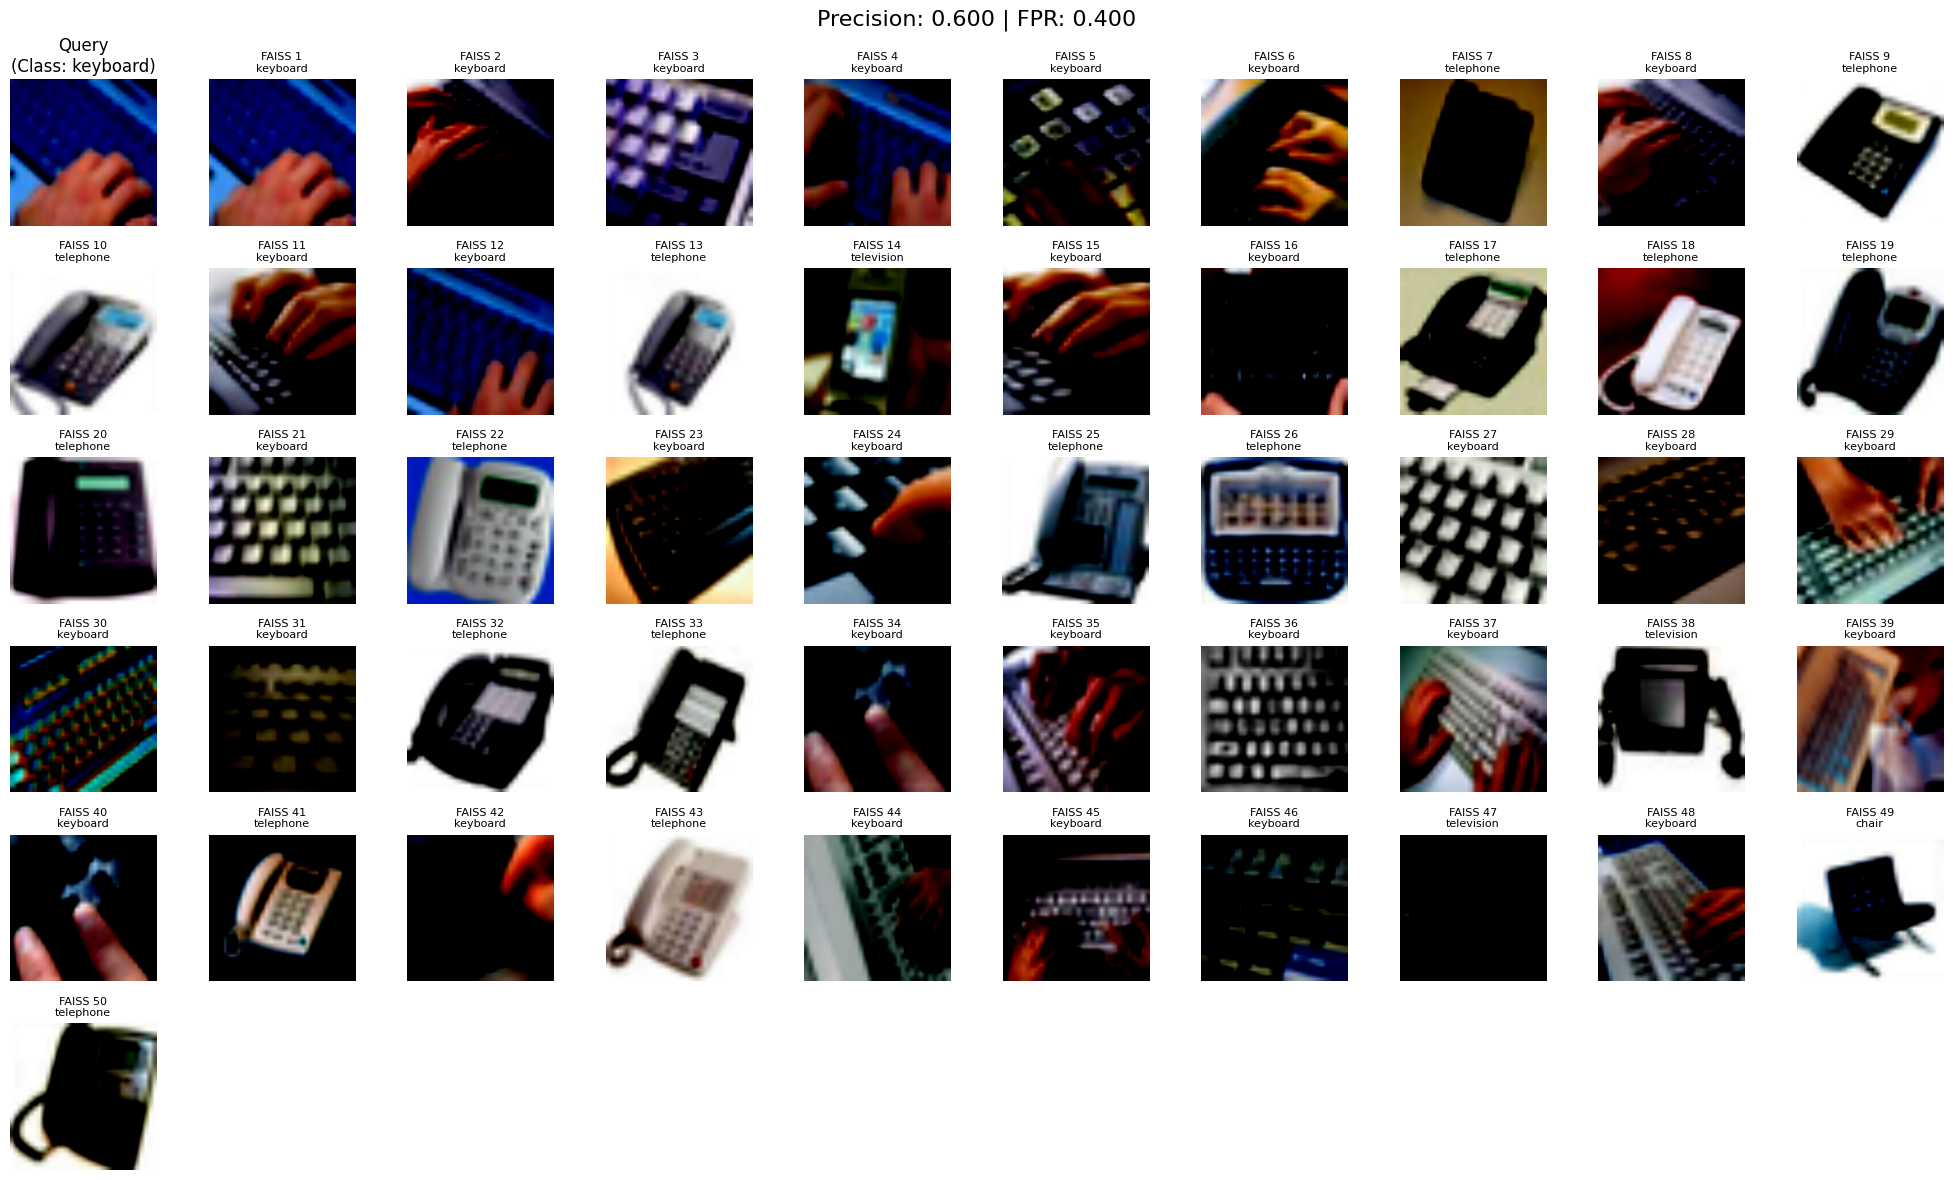


Query 3 (Index: 3330, Label: tractor):
Top-10: Precision = 0.200, FPR = 0.800
Top-20: Precision = 0.100, FPR = 0.900
Top-30: Precision = 0.067, FPR = 0.933
Top-40: Precision = 0.050, FPR = 0.950
Top-50: Precision = 0.040, FPR = 0.960


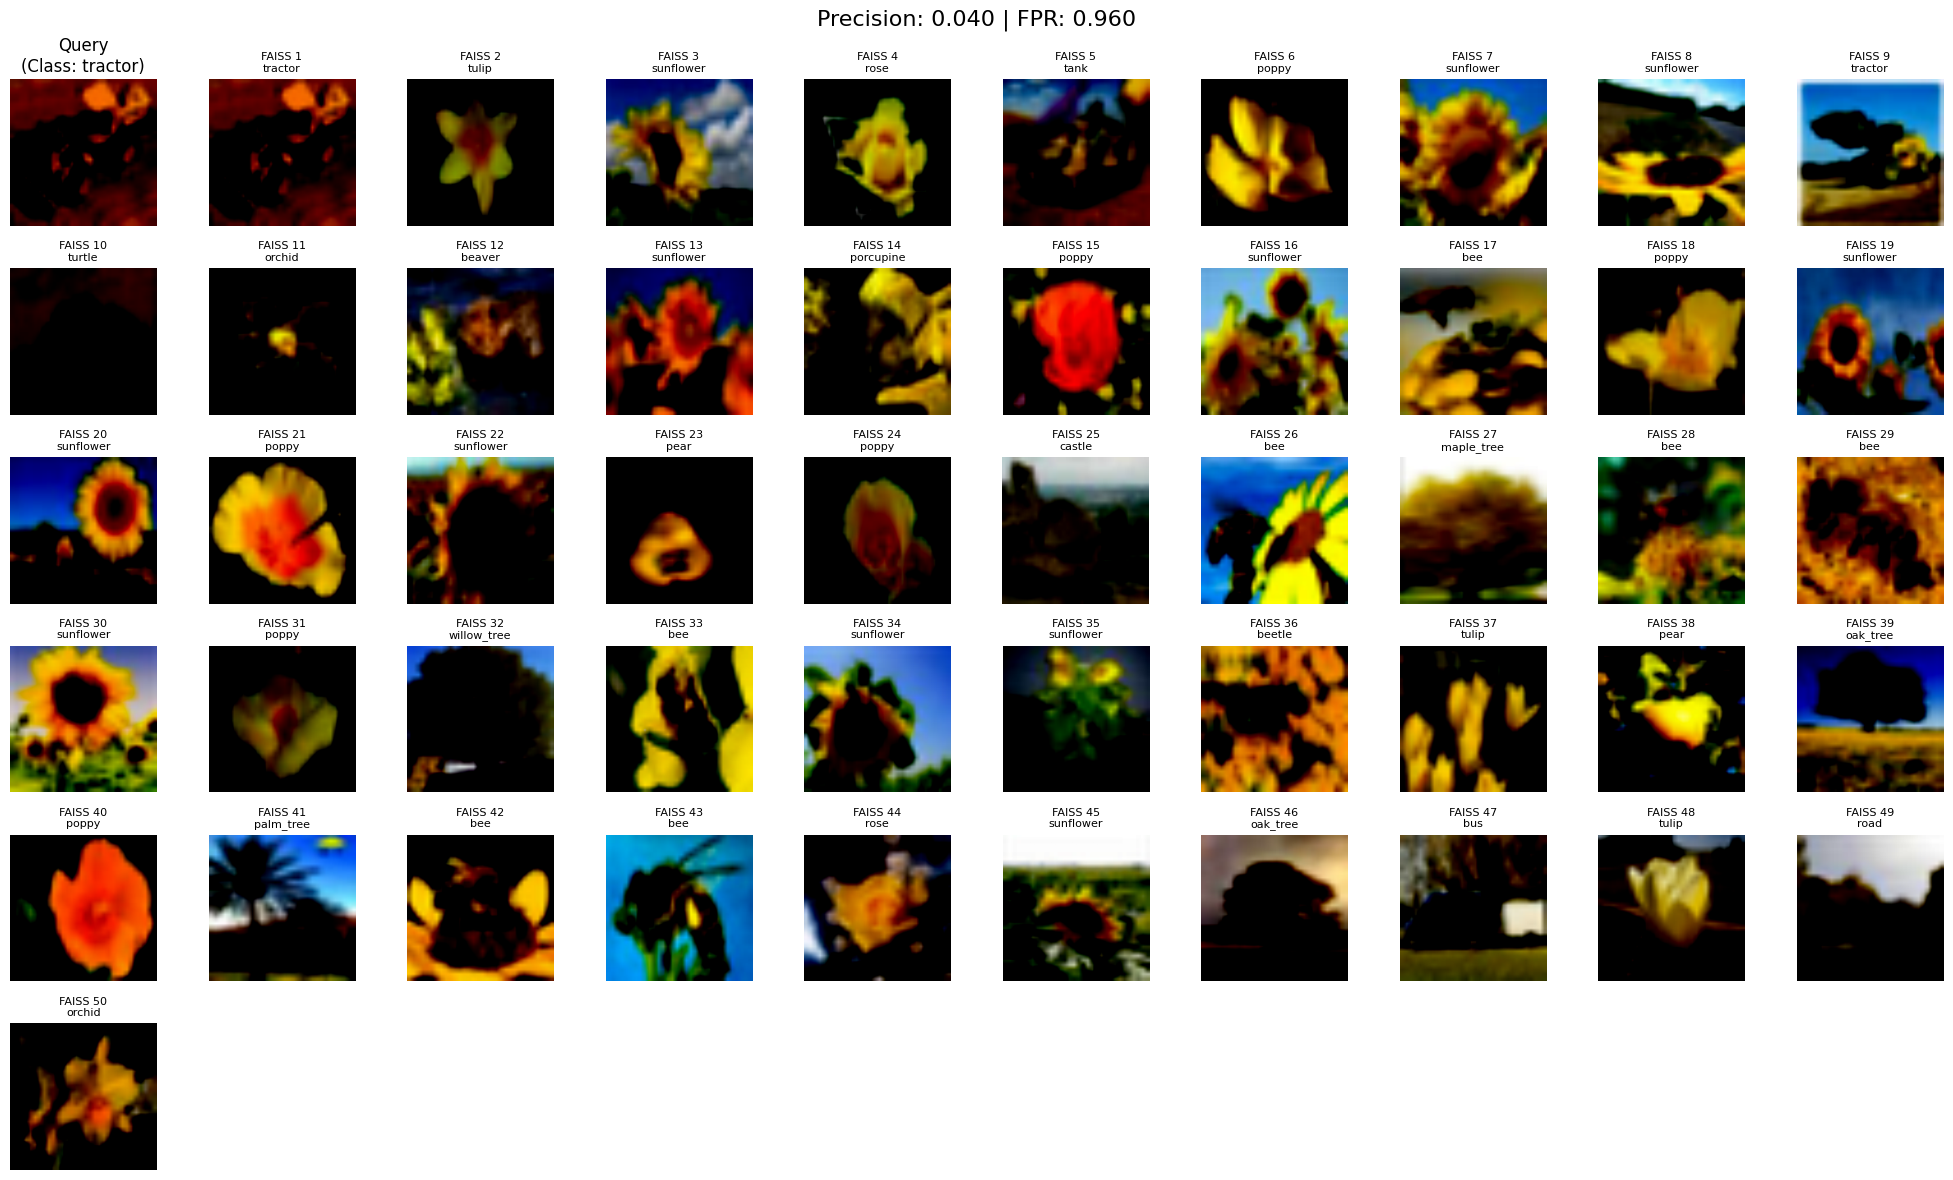


Query 4 (Index: 1024, Label: hamster):
Top-10: Precision = 0.700, FPR = 0.300
Top-20: Precision = 0.800, FPR = 0.200
Top-30: Precision = 0.700, FPR = 0.300
Top-40: Precision = 0.750, FPR = 0.250
Top-50: Precision = 0.740, FPR = 0.260


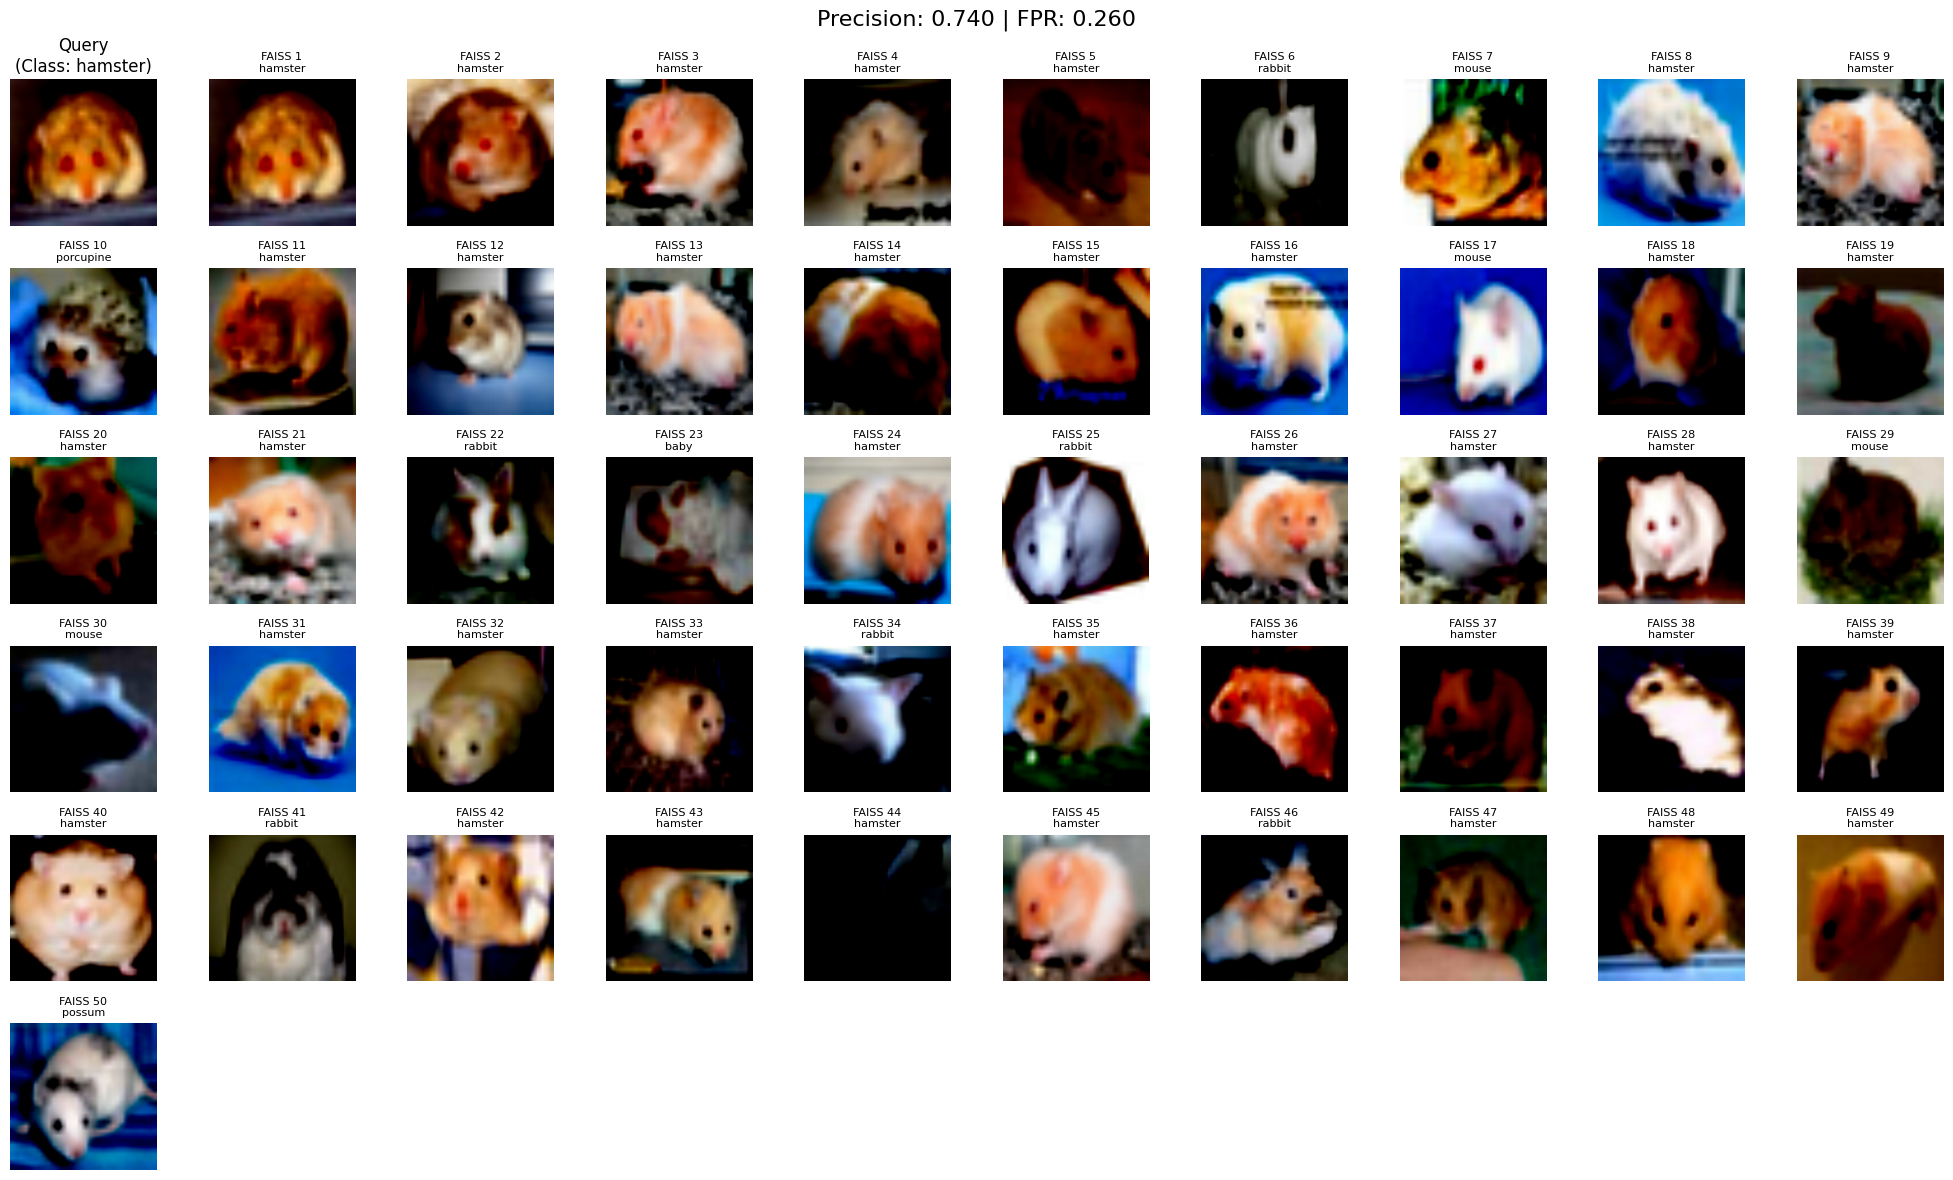


Query 5 (Index: 5789, Label: castle):
Top-10: Precision = 0.800, FPR = 0.200
Top-20: Precision = 0.800, FPR = 0.200
Top-30: Precision = 0.767, FPR = 0.233
Top-40: Precision = 0.825, FPR = 0.175
Top-50: Precision = 0.800, FPR = 0.200


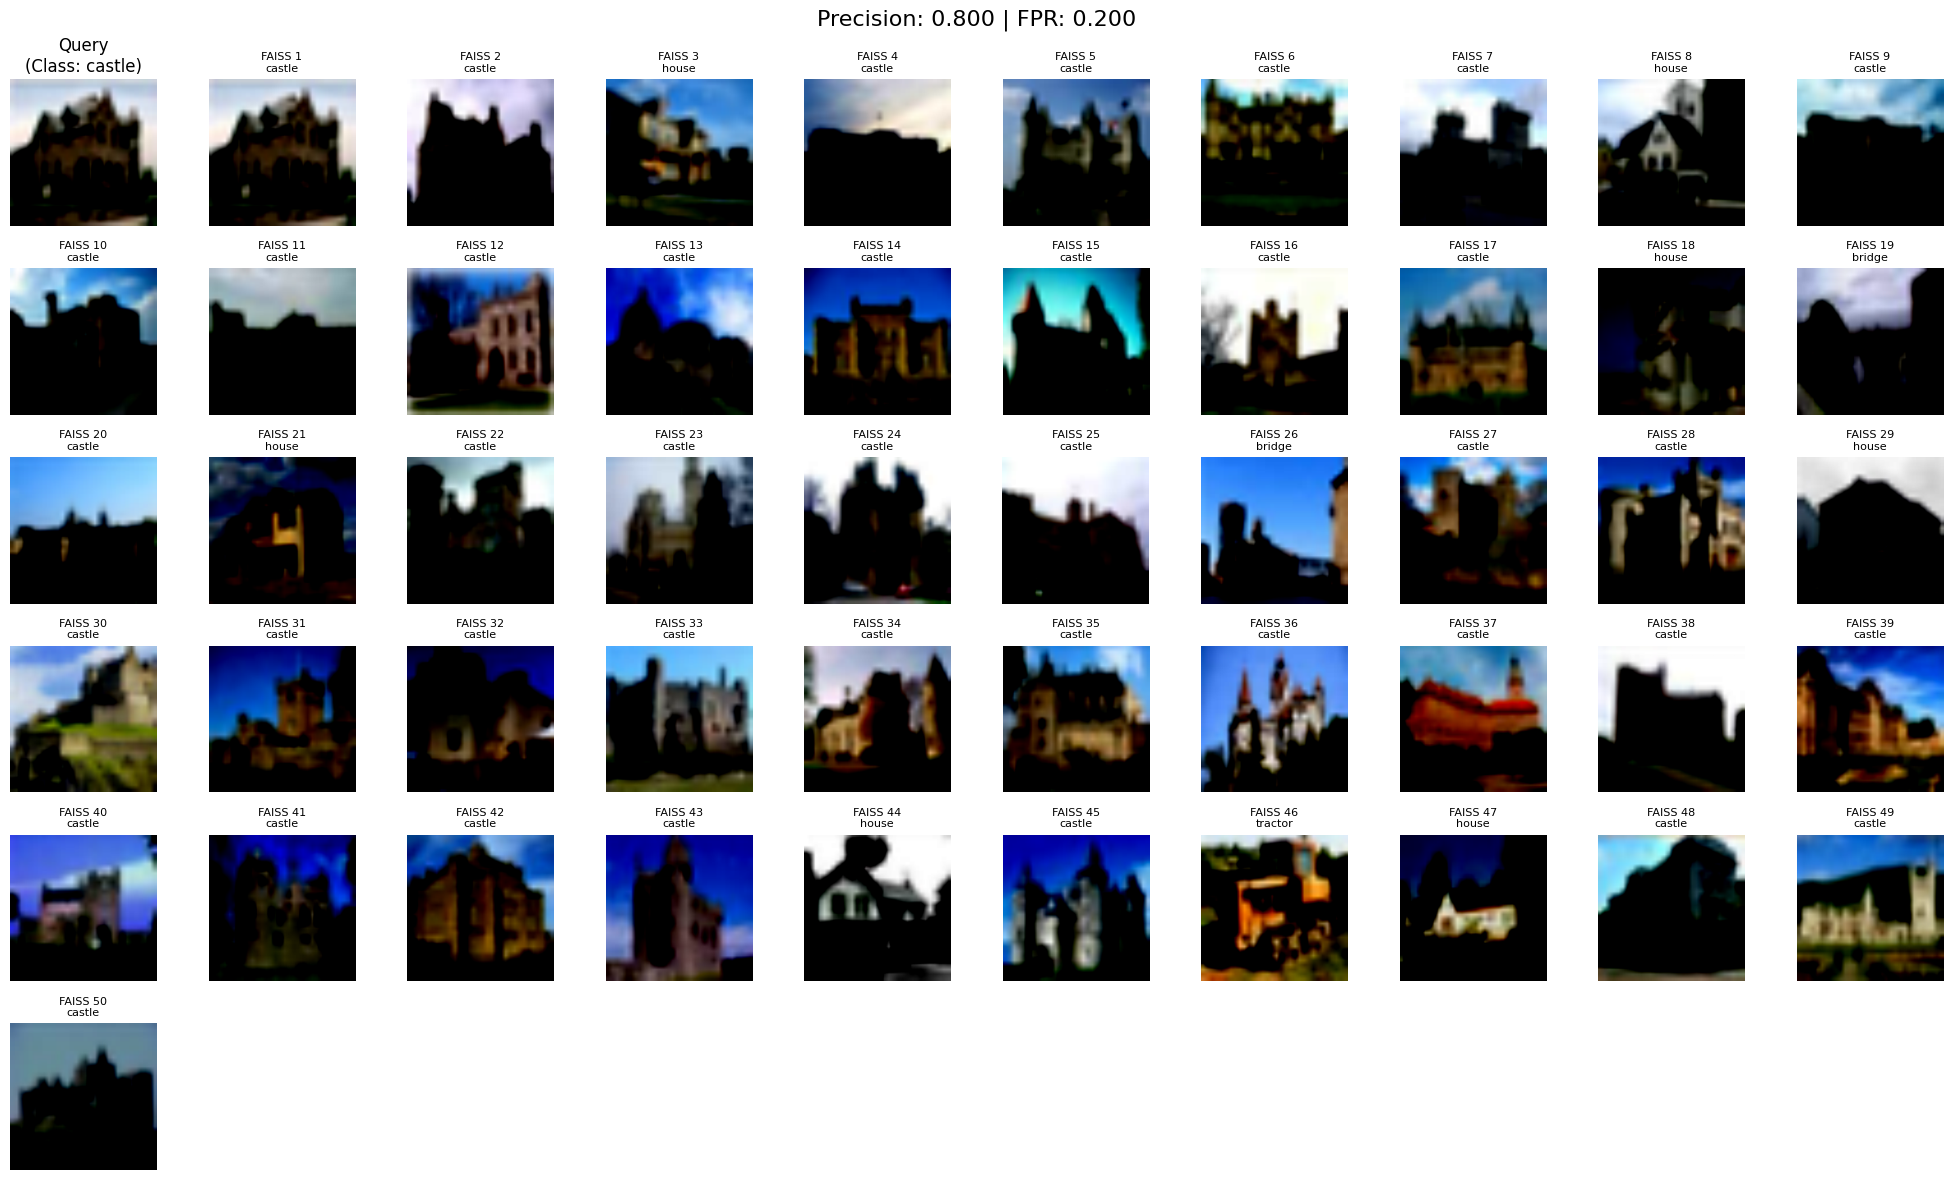

In [17]:
if __name__ == "__main__":
    print("Loading dataset and model...")
    dataset, dataloader = load_cifar100()
    label_names = dataset.classes
    labels = np.array(dataset.targets)

    embeddings = get_regnet_embeddings(dataloader)
    embeddings = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)
    faiss_index = build_faiss_index(embeddings)

    original_dataset = datasets.CIFAR100(root="./data", train=True, download=False, transform=transform)
    query_indices = [300, 10, 3330, 1024, 5789]
    ks = [10, 20, 30, 40, 50]

    for i, query_idx in enumerate(query_indices):
      query_img, query_label = original_dataset[query_idx]
      query_img_tensor = query_img.unsqueeze(0).to(device)

      with torch.no_grad():
        features = model(query_img_tensor)[-1]
        pooled = torch.nn.functional.adaptive_avg_pool2d(features, 1).squeeze(-1).squeeze(-1)
        query_embedding = pooled
        query_embedding = query_embedding / query_embedding.norm(dim=-1, keepdim=True)
        query_embedding = query_embedding.cpu().numpy()

      faiss_results = faiss_search(faiss_index, query_embedding, k=100)
      print(f"\nQuery {i+1} (Index: {query_idx}, Label: {label_names[query_label]}):")
      for k in ks:
        precision_k, fpr_k = compute_metrics([faiss_results[:k]], [query_label], labels, k)
        print(f"Top-{k}: Precision = {precision_k:.3f}, FPR = {fpr_k:.3f}")
      show_results(query_img, faiss_results, original_dataset, query_label, precision_k, fpr_k)


Processing custom image: /content/istockphoto-94323862-612x612 (1).jpg


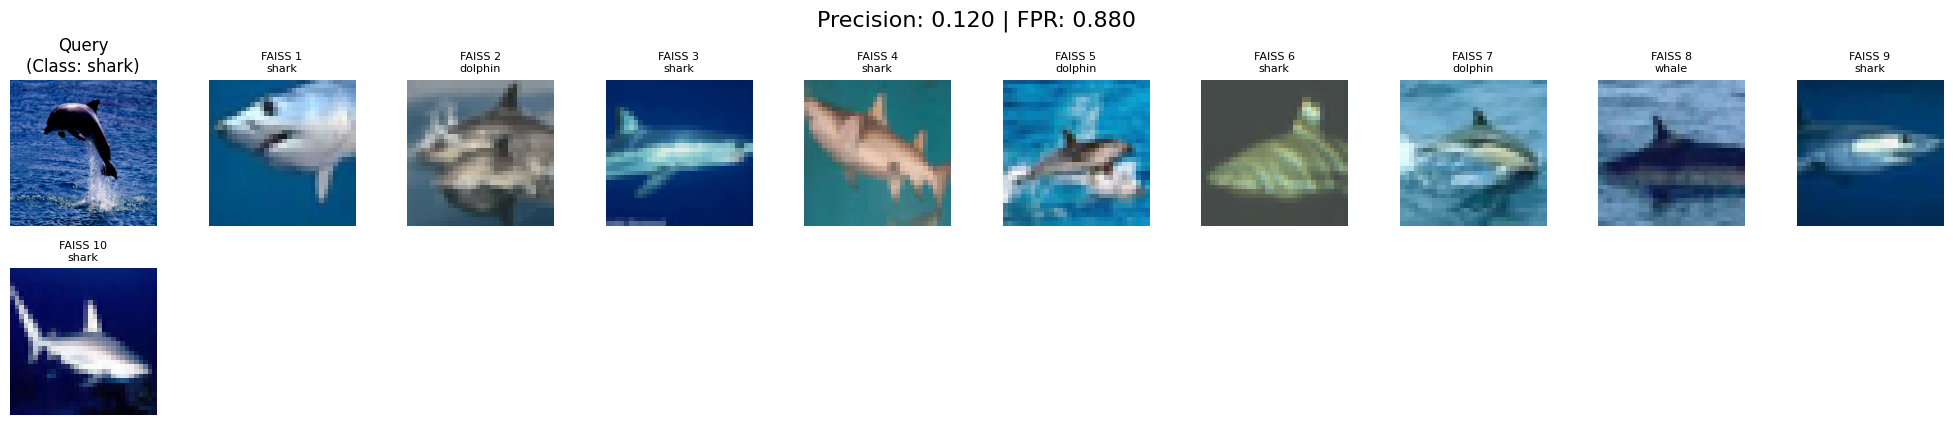


Processing custom image: /content/images (2).jpg


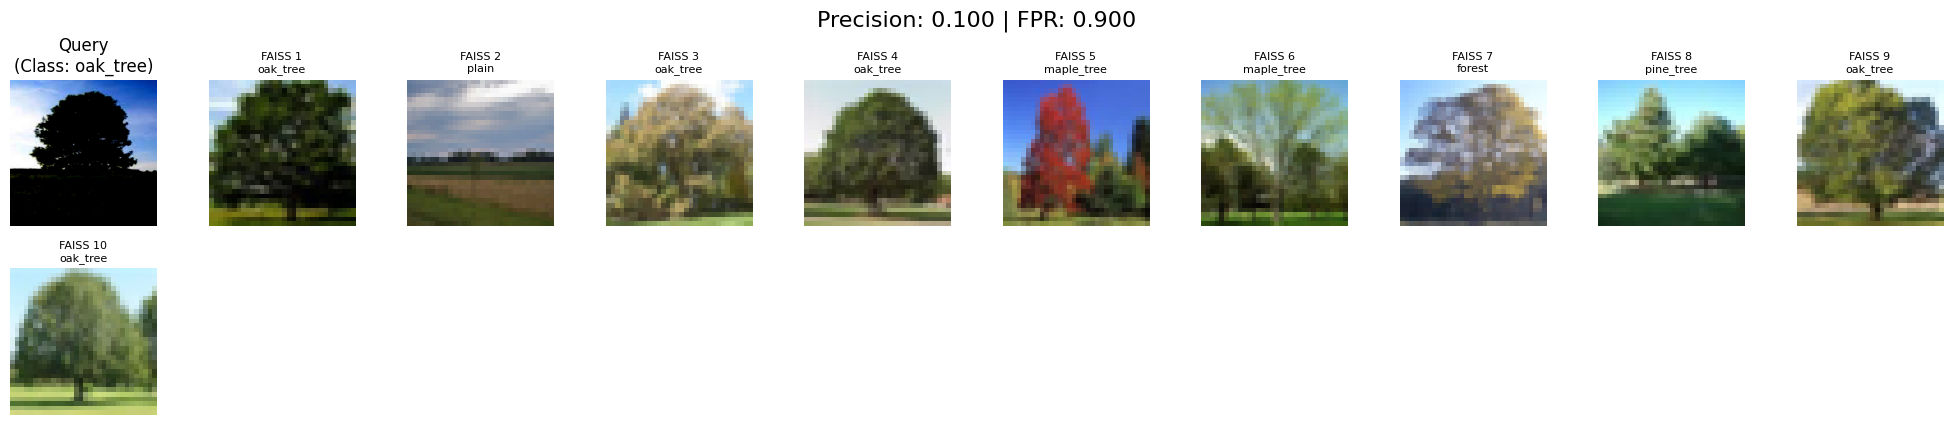


Processing custom image: /content/images (3).jpg


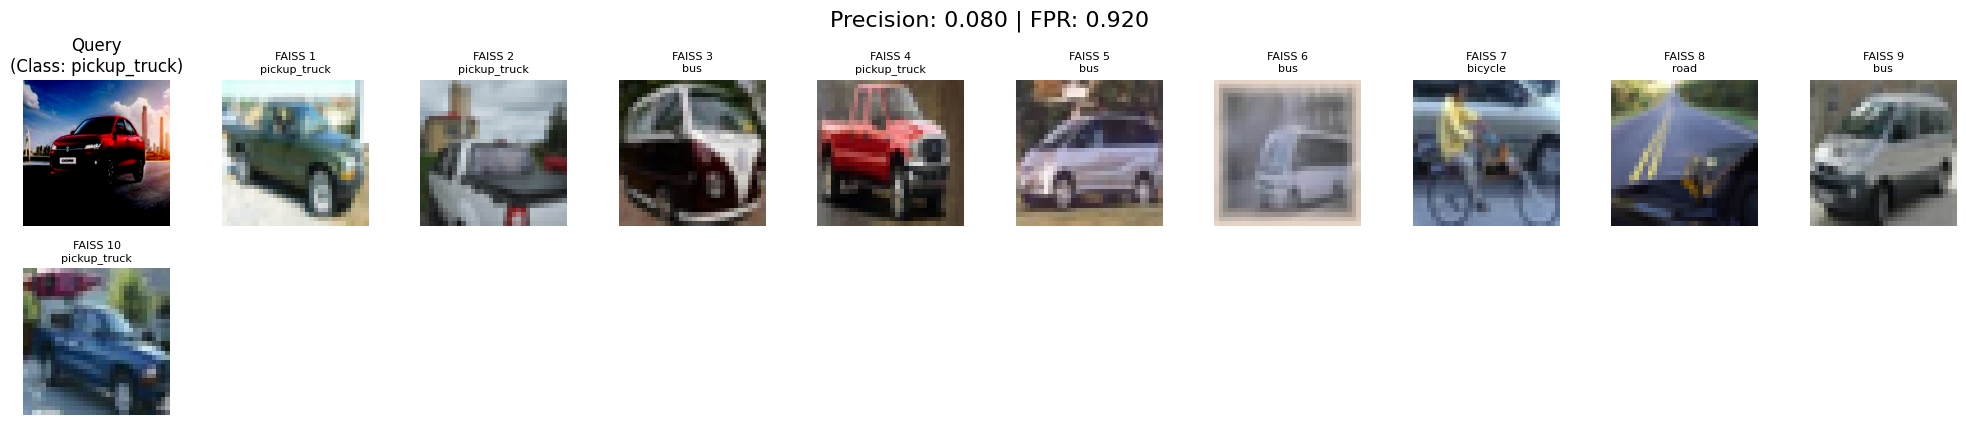

In [18]:
from PIL import Image

original_dataset = datasets.CIFAR100(root="./data", train=True, download=False, transform=transforms.ToTensor())
custom_image_paths = [
    "/content/istockphoto-94323862-612x612 (1).jpg",
    "/content/images (2).jpg",
    "/content/images (3).jpg"
]

all_query_embeddings = []
all_faiss_results = []

for i, path in enumerate(custom_image_paths):
    print(f"\nProcessing custom image: {path}")
    img = Image.open(path).convert("RGB")
    query_img = transform(img)
    input_tensor = query_img.unsqueeze(0).to(device)

    with torch.no_grad():
        features = model(input_tensor)[-1]  # Get the last feature map
        pooled = torch.nn.functional.adaptive_avg_pool2d(features, 1).squeeze(-1).squeeze(-1)
        query_embedding = pooled / pooled.norm(dim=-1, keepdim=True)
        query_embedding = query_embedding.cpu().numpy()

    faiss_results = faiss_search(faiss_index, query_embedding, k=10)

    all_query_embeddings.append(query_embedding[0])
    all_faiss_results.append(faiss_results)

    predicted_label = labels[faiss_results[0]]
    query_label = predicted_label

    precision, fpr = compute_metrics([faiss_results], [query_label], labels)

    show_results(query_img, faiss_results, original_dataset,
                 query_label=query_label, faiss_precision=precision, faiss_fpr=fpr)
